# 目标导向的强化学习

教程链接：[目标导向的强化学习](https://hrl.boyuai.com/chapter/3/%E7%9B%AE%E6%A0%87%E5%AF%BC%E5%90%91%E7%9A%84%E5%BC%BA%E5%8C%96%E5%AD%A6%E4%B9%A0)

**目标导向的强化学习**（goal-oriented reinforcement learning，GoRL）可以学习一个策略，使其可以在不同的目标（goal）作为条件下奏效，以此来解决较为复杂的决策任务。
- 奖励函数不仅与状态和动作相关，在目标导向强化学习中，还与设定的目标相关。
- 在目标导向强化学习中，由于对于不同的目标，奖励函数是不同的，因此状态价值函数$V(s,g)$也是基于目标的，动作状态价值函数$Q(s,a,g)$同理。

In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from tqdm import tqdm
import collections
import matplotlib.pyplot as plt
from typing import Tuple

## 1. HER 算法

目标导向的强化学习的奖励往往是非常稀疏的。由于智能体在训练初期难以完成目标而只能得到的奖励，从而使整个算法的训练速度较慢。**事后经验回放**（hindsight experience replay，HER）算法能有效地利用这些“失败”的经验，成为 GoRL 的一大经典方法。

首先定义一个简单二维平面上的环境。在一个二维网格世界上，每个维度的位置范围是$[0,5]$，在每一个序列的初始，智能体都处于$(0,0)$的位置，环境将自动从$3.5 \leq x,y \leq 4.5$的矩形区域内生成一个目标。每个时刻智能体可以选择纵向和横向分别移动$[-1,1]$作为这一时刻的动作。当智能体距离目标足够近的时候，它将收到的奖励0并结束任务，否则奖励为-1。每一条序列的最大长度为 50。

![](https://hrl.boyuai.com/static/480.b47ea2c8.png)

In [2]:
class WorldEnv:
    def __init__(self):
        self.distance_threshold = 0.15
        self.action_bound = 1

    def reset(self) -> np.ndarray:
        """重置环境"""
        # 生成一个目标状态, 坐标范围是[3.5～4.5, 3.5～4.5]
        self.goal = np.array(
                [4 + random.uniform(-0.5, 0.5), 4 + random.uniform(-0.5, 0.5)]
            )
        self.state = np.array([0, 0])  # 初始状态
        self.count = 0
        return np.hstack((self.state, self.goal))

    def step(self, action:np.ndarray) -> Tuple[np.ndarray, float, bool]:
        action = np.clip(action, -self.action_bound, self.action_bound)
        x = max(0, min(5, self.state[0] + action[0]))
        y = max(0, min(5, self.state[1] + action[1]))
        self.state = np.array([x, y])
        self.count += 1

        dis = np.sqrt(np.sum(np.square(self.state - self.goal)))
        reward = -1.0 if dis > self.distance_threshold else 0
        if dis <= self.distance_threshold or self.count == 50:
            done = True
        else:
            done = False

        return np.hstack((self.state, self.goal)), reward, done

接着实现DDPG算法，定义Actor和Critic网络模型。

In [3]:
class PolicyNet(nn.Module):
    def __init__(self, 
            state_dim:int, hidden_dim:int, action_dim:int, action_bound:float
        ):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound  # action_bound是环境可以接受的动作最大值

    def forward(self, x:th.Tensor) -> th.Tensor:
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        return th.tanh(self.fc3(x)) * self.action_bound


class QValueNet(nn.Module):
    def __init__(self, state_dim:int, hidden_dim:int, action_dim:int):
        super().__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x:th.Tensor, a:th.Tensor) -> th.Tensor:
        cat = th.cat([x, a], dim=1)  # 拼接状态和动作
        x = F.relu(self.fc2(F.relu(self.fc1(cat))))
        return self.fc3(x)

定义DDPG算法，在此环境里动作是2维的。

In [4]:
class DDPG:
    ''' DDPG算法 '''
    def __init__(self, 
            state_dim:int, hidden_dim:int, action_dim:int, action_bound:float,
            actor_lr:float, critic_lr:float, sigma:float, tau:float, gamma:float, 
            device:th.device
        ):
        self.action_dim = action_dim
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim, 
                                action_bound).to(device)
        self.critic = QValueNet(state_dim, hidden_dim, action_dim
                                ).to(device)
        self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim, 
                                action_bound).to(device)
        self.target_critic = QValueNet(state_dim, hidden_dim, action_dim
                                ).to(device)
        # 初始化目标价值网络并使其参数和价值网络一样
        self.target_critic.load_state_dict(self.critic.state_dict())
        # 初始化目标策略网络并使其参数和策略网络一样
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = th.optim.Adam(self.actor.parameters(),
                                            lr=actor_lr)
        self.critic_optimizer = th.optim.Adam(self.critic.parameters(),
                                            lr=critic_lr)
        self.gamma = gamma
        self.sigma = sigma  # 高斯噪声的标准差,均值直接设为0
        self.tau = tau  # 目标网络软更新参数
        self.action_bound = action_bound
        self.device = device

    def take_action(self, state:th.Tensor) -> np.ndarray:
        state = th.tensor(np.array([state]), dtype=th.float).to(self.device)
        action = self.actor(state).detach().cpu().numpy()[0]
        # 给动作添加噪声，增加探索
        action = action + self.sigma * np.random.randn(self.action_dim)
        return action

    def soft_update(self, net:nn.Module, target_net:nn.Module):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(
                param_target.data * (1.0 - self.tau) + param.data * self.tau
            )

    def update(self, transition_dict:dict):
        states = th.tensor(transition_dict['states'], 
                                dtype=th.float).to(self.device)
        actions = th.tensor(transition_dict['actions'],
                                dtype=th.float).to(self.device)
        rewards = th.tensor(transition_dict['rewards'],
                                dtype=th.float).view(-1, 1).to(self.device)
        next_states = th.tensor(transition_dict['next_states'],
                                dtype=th.float).to(self.device)
        dones = th.tensor(transition_dict['dones'],
                                dtype=th.float).view(-1, 1).to(self.device)

        next_q_values = self.target_critic(
                            next_states, self.target_actor(next_states)
                        )
        q_targets = rewards + self.gamma * next_q_values * (1 - dones)
        # MSE损失函数
        critic_loss = th.mean(
                        F.mse_loss(self.critic(states, actions), q_targets)
                    )
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # 策略网络就是为了使Q值最大化
        actor_loss = -th.mean(self.critic(states, self.actor(states)))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.actor, self.target_actor)  # 软更新策略网络
        self.soft_update(self.critic, self.target_critic)  # 软更新价值网络

接下来定义一个特殊的经验回放池，此时回放池内不再存储每一步的数据，而是存储一整条轨迹。这是 HER 算法中的核心部分，之后可以用 HER 算法从该经验回放池中构建新的数据来帮助策略训练。

In [5]:
class Trajectory:
    ''' 用来记录一条完整轨迹 '''
    def __init__(self, init_state):
        self.states = [init_state]
        self.actions = []
        self.rewards = []
        self.dones = []
        self.length = 0

    def store_step(self, action, state, reward, done):
        self.actions.append(action)
        self.states.append(state)
        self.rewards.append(reward)
        self.dones.append(done)
        self.length += 1


class ReplayBuffer_Trajectory:
    ''' 存储轨迹的经验回放池 '''
    def __init__(self, capacity:int):
        self.buffer = collections.deque(maxlen=capacity)

    def add_trajectory(self, trajectory:Trajectory):
        self.buffer.append(trajectory)

    def size(self) -> int:
        return len(self.buffer)

    def sample(self, 
            batch_size:int, use_her:bool, dis_threshold:float=0.15, 
            her_ratio:float=0.8
        ) -> dict:
        batch = dict(states=[],
                     actions=[],
                     next_states=[],
                     rewards=[],
                     dones=[])
        for _ in range(batch_size):
            traj = random.sample(self.buffer, 1)[0]
            step_state = np.random.randint(traj.length)
            state = traj.states[step_state]
            next_state = traj.states[step_state + 1]
            action = traj.actions[step_state]
            reward = traj.rewards[step_state]
            done = traj.dones[step_state]

            if use_her and np.random.uniform() <= her_ratio:
                step_goal = np.random.randint(step_state + 1, traj.length + 1)
                goal = traj.states[step_goal][:2]  # 使用HER算法的future方案设置目标
                dis = np.sqrt(np.sum(np.square(next_state[:2] - goal)))
                reward = -1.0 if dis > dis_threshold else 0
                done = False if dis > dis_threshold else True
                state = np.hstack((state[:2], goal))
                next_state = np.hstack((next_state[:2], goal))

            batch['states'].append(state)
            batch['next_states'].append(next_state)
            batch['actions'].append(action)
            batch['rewards'].append(reward)
            batch['dones'].append(done)

        batch['states'] = np.array(batch['states'])
        batch['next_states'] = np.array(batch['next_states'])
        batch['actions'] = np.array(batch['actions'])
        return batch

Iteration 9: 100%|██████████| 200/200 [01:01<00:00,  3.25it/s, episode=2000, return=-4.300]


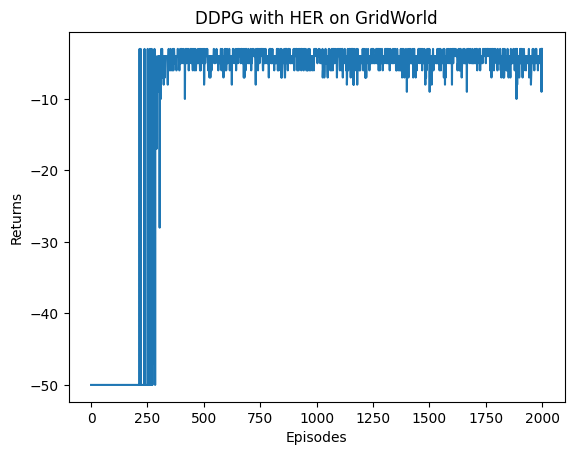

In [6]:
actor_lr = 1e-3
critic_lr = 1e-3
hidden_dim = 128
state_dim = 4
action_dim = 2
action_bound = 1
sigma = 0.1
tau = 0.005
gamma = 0.98
num_episodes = 2000
n_train = 20
batch_size = 256
minimal_episodes = 200
buffer_size = 10000
device = th.device("cuda") if th.cuda.is_available() else th.device("cpu")

random.seed(0)
np.random.seed(0)
th.manual_seed(0)
env = WorldEnv()
replay_buffer = ReplayBuffer_Trajectory(buffer_size)
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, actor_lr,
             critic_lr, sigma, tau, gamma, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            traj = Trajectory(state)
            done = False
            while not done:
                action = agent.take_action(state)
                state, reward, done = env.step(action)
                episode_return += reward
                traj.store_step(action, state, reward, done)
            replay_buffer.add_trajectory(traj)
            return_list.append(episode_return)
            if replay_buffer.size() >= minimal_episodes:
                for _ in range(n_train):
                    transition_dict = replay_buffer.sample(batch_size, True)
                    agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG with HER on {}'.format('GridWorld'))
plt.show()

接下来尝试不采用 HER 重新构造数据，而是直接使用收集的数据训练一个策略，看看是什么效果。

Iteration 9: 100%|██████████| 200/200 [00:42<00:00,  4.76it/s, episode=2000, return=-50.000]


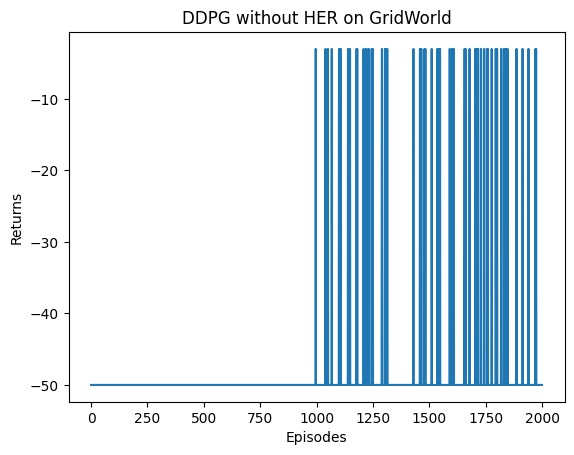

In [7]:
random.seed(0)
np.random.seed(0)
th.manual_seed(0)
env = WorldEnv()
replay_buffer = ReplayBuffer_Trajectory(buffer_size)
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, actor_lr,
             critic_lr, sigma, tau, gamma, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            traj = Trajectory(state)
            done = False
            while not done:
                action = agent.take_action(state)
                state, reward, done = env.step(action)
                episode_return += reward
                traj.store_step(action, state, reward, done)
            replay_buffer.add_trajectory(traj)
            return_list.append(episode_return)
            if replay_buffer.size() >= minimal_episodes:
                for _ in range(n_train):
                    # 和使用HER训练的唯一区别
                    transition_dict = replay_buffer.sample(batch_size, False)
                    agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG without HER on {}'.format('GridWorld'))
plt.show()

通过实验对比，可以观察到使用 HER 算法后，效果有显著提升。这里 HER 算法的主要好处是通过重新对历史轨迹设置其目标（使用 future 方案）而使得奖励信号更加稠密，进而从原本失败的数据中学习到使“新任务”成功的经验，提升训练的稳定性和样本效率。

从 HER 的代码实践中还可以领会一种思维方式，即可以通过整条轨迹的信息来改善每个转移片段带给智能体策略的学习价值。例如，在 HER 算法的 future 方案中，采样当前轨迹后续的状态作为目标，然后根据下一步状态是否离目标足够近来修改当前步的奖励信号。此外，HER 算法只是一个经验回放的修改方式，并没有对策略网络和价值网络的架构做出任何修改。